In [1]:
# !pip install pretrainedmodels

In [18]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

import torch.nn.functional as F
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
import pretrainedmodels
import os
from torch.utils.data import Dataset
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import time
import numpy as np
import pandas as pd
import os
import datetime as dt
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets, models

!pip install ipdb
import ipdb

%matplotlib inline

PyTorch Version:  1.5.0+cu101
Torchvision Version:  0.6.0+cu101


In [19]:
data_path = "./data/train/train"
test_path = "./data/test/test"
extraimage_path = "./data/extraimages/extraimages"

In [20]:
print('Train set:')
class_distrbution = {}
for cls in os.listdir(data_path):
    print('{}:{}'.format(cls, len(os.listdir(os.path.join(data_path, cls)))))
    class_distrbution[cls] =  len(os.listdir(os.path.join(data_path, cls)))
im = Image.open(data_path+'/cgm/train-cgm-738.jpg')
print(im.size)
class_distrbution

Train set:
cmd:2658
healthy:316
cgm:773
cbb:466
cbsd:1443
(500, 500)


{'cbb': 466, 'cbsd': 1443, 'cgm': 773, 'cmd': 2658, 'healthy': 316}

In [21]:
# Transformations for both the training and testing data
mean=[0.4543, 0.5137, 0.3240]
std=[0.1949, 0.1977, 0.1661]


train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224), #448, 299, 224, 331
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                      transforms.Normalize(mean=mean,std=std)])

test_transforms = transforms.Compose([ transforms.Resize(224),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                      transforms.Normalize(mean=mean,std=std)])

# normalize = transforms.Normalize(mean=mean, std=std)

In [22]:
class CassavaDataset(Dataset):
    def __init__(self, path, transform=None):
        self.classes = os.listdir(path)
        self.path = [f"{path}/{className}" for className in self.classes]
        self.file_list = [glob.glob(f"{x}/*") for x in self.path]
        self.transform = transform

        files = []
        class_names = {}
        for i, className in enumerate(self.classes):
            for fileName in self.file_list[i]:
                files.append([i, className, fileName])

                name = str(i)+'-'+className
                if name not in class_names:
                    class_names[name] = 1
                else:
                    class_names[name] += 1
        self.file_list = files
        print(class_names)
        files = None

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        fileName = self.file_list[idx][2]
        classCategory = self.file_list[idx][0]
        im = Image.open(fileName)
        if self.transform:
            im = self.transform(im)
        
# #         return im.view(3, 448, 448), classCategory
        return im.view(3, 224, 224), classCategory
# #         return im.view(3, 299, 299), classCategory
#         return im.view(3, 331, 331), classCategory   # NASNetLarge 331x331

In [23]:
train_data = CassavaDataset(data_path, transform=train_transforms)

test_data = CassavaDataset(test_path, transform=test_transforms)

extraimage_data = CassavaDataset(extraimage_path, transform=train_transforms) #maybe need an other trasforms, I had to change the dataset structure :)

{'0-cmd': 2658, '1-healthy': 316, '2-cgm': 773, '3-cbb': 466, '4-cbsd': 1443}
{'0-0': 3774}
{'0-0': 12595}


In [24]:
from torch.utils.data.sampler import SubsetRandomSampler

validation_split = 0.2
shuffle_dataset = True
random_seed= 42 #42

# Creating data indices for training and validation splits:
dataset_size = len(train_data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

In [25]:
# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

batch_size = 16 #16

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                             sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                             sampler=valid_sampler)

unlabeled_loader = torch.utils.data.DataLoader(extraimage_data, batch_size=batch_size) # to make batch_size work, I had to moove all the unlabeled data in a 0 folder

test_loader = torch.utils.data.DataLoader(test_data, batch_size=1) # make batch = 1 here 

In [27]:
total_train = 0
from collections import Counter

Classes = Counter()

for i, (data, label) in enumerate(train_loader):
    total_train += i
    Classes.update(label.tolist())# += 1 

In [28]:
total_train

39903

In [29]:
Classes

Counter({0: 2108, 1: 257, 2: 622, 3: 375, 4: 1163})

In [30]:
valid_train = 0
from collections import Counter

Classes_valid = Counter()

for i, (data, label) in enumerate(valid_loader):
    valid_train += i
    Classes_valid.update(label.tolist())# += 1 

In [32]:
valid_train

2485

In [31]:
Classes_valid

Counter({0: 550, 1: 59, 2: 151, 3: 91, 4: 280})

In [26]:
# # Creating PT data samplers and loaders:
# # train_sampler = SubsetRandomSampler(train_indices)
# # valid_sampler = SubsetRandomSampler(val_indices)
# from torch.utils.data.sampler import SubsetRandomSampler,WeightedRandomSampler
# #-----------------------------------------------------------------------------z

# validation_split = 0.2
# shuffle_dataset = True
# random_seed= 42

# # ipdb.set_trace()
# # Creating data indices for training and validation splits:
# dataset_size = len(train_data)
# indices = list(range(dataset_size))
# split = int(np.floor(validation_split * dataset_size))

# if shuffle_dataset :
#     np.random.seed(random_seed)
#     np.random.shuffle(indices)

# train_indices, val_indices = indices[split:], indices[:split]


# # get target

# targets=[]
# #data=[]
# file_list =train_data.file_list
# np.random.shuffle(file_list)

# for i in file_list:
#     targets.append(i[0])
#    # data.append(i[2])
    
# target_train=targets[split:]
# # train_set=data[split:]
# # print(len(train_set))

# target_test=targets[:split]
# #test_set=data[:split]



    
# # for i in test_data.file_list:
# #     test_targets.append(i[0])
    
# # target = torch.cat((torch.zeros(int(len(train_data) * 0.99), dtype=torch.long),
# #                     torch.ones(int(len(train_data) * 0.01), dtype=torch.long)))


# #count classes
# class_count = np.unique(target_train ,return_counts=True)[1]
# #print(class_count)
# class_count_test= np.unique(target_test, return_counts=True)[1]


# #--------------------------------------------------------------------
# # get weights train

# weight_train = 1. / class_count
# #print(targets)
# samples_weight_train = weight_train[target_train]
# #print(samples_weight_train )

# samples_weight_train = torch.from_numpy(samples_weight_train)
# #print(samples_weight_train)
# sampler_train = WeightedRandomSampler(samples_weight_train, len(samples_weight_train))

# #### valid



# weight_test = 1. / class_count_test
# #print(targets)
# samples_weight_test = weight_test[target_test]
# #print(samples_weight_train )

# samples_weight_test = torch.from_numpy(samples_weight_test)
# #print(samples_weight_train)
# sampler_valid = WeightedRandomSampler(samples_weight_test, len(samples_weight_test))


# train_loader = torch.utils.data.DataLoader(train_data, batch_size = 16,
#                                              sampler = sampler_train)


# valid_loader = torch.utils.data.DataLoader(train_data, batch_size = 16,
#                                              sampler = sampler_valid)


# unlabeled_loader = torch.utils.data.DataLoader(extraimage_data, batch_size = 16, 
#                                               shuffle = True, num_workers = 2) # to make batch_size work, I had to moove all the unlabeled data in a 0 folder

# test_loader = torch.utils.data.DataLoader(test_data, batch_size=1) # make batch = 1 here 

In [8]:
total_train = 0
from collections import Counter

Classes = Counter()

for i, (data, label) in enumerate(train_loader):
    total_train += i
    Classes.update(label.tolist())# += 1 

In [9]:
total_train

39903

In [10]:
Classes

Counter({0: 2142, 1: 264, 2: 661, 3: 367, 4: 1091})

In [11]:
12720

12720

In [12]:
# P = next(train_loader.__iter__())[1]

In [13]:
# P.tolist()

In [14]:
# Classes

In [15]:
valid_train = 0
from collections import Counter

Classes_valid = Counter()

for i, (data, label) in enumerate(valid_loader):
    valid_train += i
    Classes_valid.update(label.tolist())# += 1 

In [16]:
valid_train

2485

In [17]:
Classes_valid

Counter({0: 225, 1: 208, 2: 242, 3: 226, 4: 230})

In [14]:
inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std=[1/s for s in std]
)

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = inv_normalize(img)# / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.figure(figsize=(20,20))
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


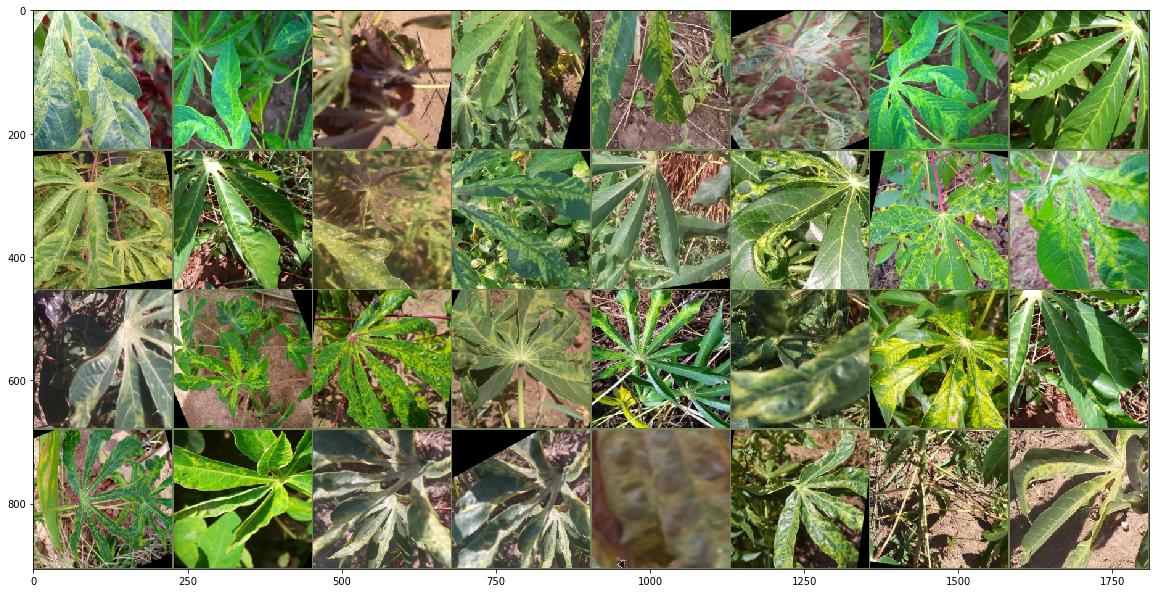

In [27]:
dataiter = iter(valid_loader)
images, labels = dataiter.next()

print(labels)
img_grid = torchvision.utils.make_grid(images)

matplotlib_imshow(img_grid, one_channel=False)

In [8]:
from torch.utils.data.sampler import SubsetRandomSampler

validation_split = 0.2
shuffle_dataset = True
random_seed= 42 #42

# Creating data indices for training and validation splits:
dataset_size = len(train_data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

In [9]:
# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

batch_size = 16

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                             sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                             sampler=valid_sampler)

# unlabeled_loader = torch.utils.data.DataLoader(extraimage_data, batch_size=batch_size) # to make batch_size work, I had to moove all the unlabeled data in a 0 folder

# test_loader = torch.utils.data.DataLoader(test_data, batch_size=1) # make batch = 1 here 

In [10]:
# train_loader

In [11]:
# for data,label in valid_loader:
#     print(label)
#     break
# #     

In [12]:
inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std=[1/s for s in std]
)

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = inv_normalize(img)# / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.figure(figsize=(20,20))
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [13]:
# dataiter = iter(unlabeled_loader)
# images, labels = dataiter.next()

# print(labels)
# img_grid = torchvision.utils.make_grid(images)

# matplotlib_imshow(img_grid, one_channel=False)

In [14]:
class Additional(nn.Module):
    def __init__(self, modelA,in_features,nb_classes=5, freeze = False):
        super(Additional, self).__init__()
        self.modelA = modelA
        # Remove last linear layer
#         self.modelA.fc = nn.Identity() # for resnet
        self.modelA.last_linear = nn.Identity() #for re_renext
#         self.modelA.classifier = nn.Identity()    # densenet201
        for p in self.modelA.parameters():
            if freeze:
                p.requires_grad = False
            else :
                p.requires_grad = True
        
        # Create new classifier
        self.fc_1 = nn.Linear(in_features,256)
        self.fc_2 = nn.Linear(256,  512)
        self.fc_out = nn.Linear( 512, nb_classes)
        
        #Dropout
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        #model
        x = self.modelA(x.clone())  
        x = x.view(x.size(0), -1)
        
        #FC
        x  = self.dropout(self.fc_1(F.relu(x)))
        x = self.dropout(self.fc_2(F.relu(x)))
        x = self.fc_out(F.relu(x))
        
        return x

In [15]:
# this function is used during training process, to calculation the loss and accuracy
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [16]:
total_loss_train, total_acc_train = [],[]
def train(train_loader, model, criterion, optimizer, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        # print('image shape:',images.size(0), 'label shape',labels.size(0))
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg

In [17]:
def validate(val_loader, model, criterion, optimizer, epoch):
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            images, labels = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

In [18]:
# import ipdb
# {'0-cbsd': 1443, '1-cgm': 773, '2-cbb': 466, '3-healthy': 316, '4-cmd': 2658}

In [19]:
def test(test_loader, model):
    model.eval()
    pred = []
    _class_labels = np.array(['cbsd','cgm','cbb','healthy','cmd'])
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            images, _ = data
            images = Variable(images).to(device)
    
            outputs = model(images)
    
            prediction = outputs.data.cpu().numpy().argmax()
            
            _predicted_class_labels = _class_labels[prediction]
            
            pred.append(_predicted_class_labels)

    return pred

In [20]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model_name = 'se_resnext101_32x4d' # se_resnext101_32x4d, resnext101_64x4d, nasnetlarge
# # resnet_model = torch.hub.load('pytorch/vision:v0.5.0', model_name, pretrained=True)
# resnet_model = pretrainedmodels.se_resnext101_32x4d(num_classes=1000, pretrained="imagenet")# todo : how to pretrained=False ?

# # num_fits = resnet_model.fc.in_features
# num_fits = resnet_model.last_linear.in_features # se_resnext101_32x4d
# # num_fits = resnet_model.classifier.in_features # densenet201
# num_fits


# model = Additional(resnet_model, num_fits, freeze = False)
# model = model.to(device)
# # model

# #---------------------------------------------

# lr = 2e-4 # 0.001
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=lr)

In [21]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# train_loader.dataset.classes,
# class_weights = [class_distrbution[i] for i in train_loader.dataset.classes]
# class_weights_normalized = [max(class_weights)/i for i in class_weights]

# class_weights_normalized,torch.Tensor(class_weights_normalized)

# x = torch.Tensor(class_weights_normalized)
# x = x.to(device)
# x = x
# x,class_distrbution

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = 'se_resnext101_32x4d' # se_resnext101_32x4d, resnext101_64x4d, nasnetlarge
# resnet_model = torch.hub.load('pytorch/vision:v0.5.0', model_name, pretrained=True)
resnet_model = pretrainedmodels.se_resnext101_32x4d(num_classes=1000, pretrained="imagenet")# todo : how to pretrained=False ?

# resnet_model = torchvision.models.resnet50(pretrained=True)
#---------------------------------------------

# num_fits = resnet_model.fc.in_features
num_fits = resnet_model.last_linear.in_features # se_resnext101_32x4d
# num_fits = resnet_model.classifier.in_features # densenet201
num_fits


model = Additional(resnet_model, num_fits, freeze = False)
model = model.to(device)
# model

#---------------------------------------------

lr = 2e-4 # 0.001
# criterion = nn.CrossEntropyLoss(weight = x)
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=lr)


epoch_num = 5
best_val_acc = 0.86
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(valid_loader, model, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        torch.save(model.state_dict(), model_name+'freeze_'+str(best_val_acc)[:4]+'.ckpt')
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

[epoch 1], [iter 100 / 404], [train loss 0.98272], [train acc 0.62750]
[epoch 1], [iter 200 / 404], [train loss 0.93122], [train acc 0.64875]
[epoch 1], [iter 300 / 404], [train loss 0.88776], [train acc 0.66417]
[epoch 1], [iter 400 / 404], [train loss 0.86619], [train acc 0.67125]
------------------------------------------------------------
[epoch 1], [val loss 0.77475], [val acc 0.68845]
------------------------------------------------------------
[epoch 2], [iter 100 / 404], [train loss 0.71262], [train acc 0.72000]
[epoch 2], [iter 200 / 404], [train loss 0.70382], [train acc 0.72562]
[epoch 2], [iter 300 / 404], [train loss 0.69537], [train acc 0.72875]
[epoch 2], [iter 400 / 404], [train loss 0.70119], [train acc 0.72437]
------------------------------------------------------------
[epoch 2], [val loss 0.59672], [val acc 0.76071]
------------------------------------------------------------
[epoch 3], [iter 100 / 404], [train loss 0.65458], [train acc 0.74375]


In [41]:
lr = 2e-4 # 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


epoch_num = 5
best_val_acc = 0.88
total_loss_val, total_acc_val = [],[]
for epoch in range(1, epoch_num+1):
    loss_train, acc_train = train(train_loader, model, criterion, optimizer, epoch)
    loss_val, acc_val = validate(valid_loader, model, criterion, optimizer, epoch)
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        torch.save(model.state_dict(), model_name+'freeze_'+str(best_val_acc)[:4]+'.ckpt')
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

[epoch 1], [iter 100 / 283], [train loss 0.61743], [train acc 0.78438]
[epoch 1], [iter 200 / 283], [train loss 0.62202], [train acc 0.78438]
------------------------------------------------------------
[epoch 1], [val loss 0.51200], [val acc 0.82666]
------------------------------------------------------------
[epoch 2], [iter 100 / 283], [train loss 0.53805], [train acc 0.81000]
[epoch 2], [iter 200 / 283], [train loss 0.55794], [train acc 0.80781]
------------------------------------------------------------
[epoch 2], [val loss 0.51778], [val acc 0.82843]
------------------------------------------------------------
[epoch 3], [iter 100 / 283], [train loss 0.53769], [train acc 0.81812]
[epoch 3], [iter 200 / 283], [train loss 0.53720], [train acc 0.81281]
------------------------------------------------------------
[epoch 3], [val loss 0.55713], [val acc 0.80250]
------------------------------------------------------------
[epoch 4], [iter 100 / 283], [train loss 0.53631], [train acc

In [22]:
# model

In [68]:
# # load better model
model.load_state_dict(torch.load('se_resnext101_32x4dfreeze_0.88_all.ckpt'))
# loss_val, acc_val = validate(valid_loader, model, criterion, optimizer, 1)
# model.eval()

<All keys matched successfully>

In [69]:
loss_val, acc_val = validate(valid_loader, model, criterion, optimizer, 1)

------------------------------------------------------------
[epoch 1], [val loss 0.33241], [val acc 0.88748]
------------------------------------------------------------


### Test Time Augmentation TTA

In [22]:
# !pip install git+https://github.com/qubvel/ttach

import ttach as tta

In [26]:
transforms = tta.Compose(
    [
        tta.HorizontalFlip(),
        tta.Rotate90(angles=[0, 180]),
#         tta.Scale(scales=[1, 2, 4]),
#         tta.Multiply(factors=[0.9, 1, 1.1]),        
    ]
)

tta_model = tta.ClassificationTTAWrapper(model, transforms)

loss_val, acc_val = validate(valid_loader, tta_model, criterion, optimizer, 5)

# # #---------------------------------------------

# lr = 2e-4 # 0.001
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=lr)


# epoch_num = 5
# best_val_acc = 0.88
# total_loss_val, total_acc_val = [],[]

# for epoch in range(1, epoch_num+1):
#     loss_train, acc_train = train(train_loader, tta_model, criterion, optimizer, epoch)
#     loss_val, acc_val = validate(valid_loader, tta_model, criterion, optimizer, epoch)
#     total_loss_val.append(loss_val)
#     total_acc_val.append(acc_val)
#     if acc_val > best_val_acc:
#         best_val_acc = acc_val
#         torch.save(model.state_dict(), model_name+'freeze_'+str(best_val_acc)[:4]+'.ckpt')
#         print('*****************************************************')
#         print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
#         print('*****************************************************')
        
# # tta_model = tta.ClassificationTTAWrapper(model, tta.aliases.five_crop_transform())

------------------------------------------------------------
[epoch 5], [val loss 0.40387], [val acc 0.87089]
------------------------------------------------------------


In [43]:
# tta_model

In [ ]:
loss_val, acc_val = validate(train_loader, tta_model, criterion, optimizer, epoch)

## Pseudo Labelling

In [55]:
T1 = 100
T2 = 700
af = 3

def alpha_weight(epoch):
    if epoch < T1:
        return 0.0
    elif epoch > T2:
        return af
    else:
         return ((epoch-T1) / (T2-T1))*af

In [56]:
best_val_acc

0.87

In [ ]:
total_loss_train, total_acc_train = [],[]
def semi_superv_train(train_loader, model, criterion, optimizer, unlabeled_loader, valid_loader, epoch):
    
    model.eval()
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    with torch.no_grad():
        for i, data in enumerate(unlabeled_loader):
            images, _ = data
            N = images.size(0)
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)

            outputs = model(images)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)

            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print('[epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, val_loss.avg, val_acc.avg))
    print('------------------------------------------------------------')
    return val_loss.avg, val_acc.avg

    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(unlabeled_loader):
        images, labels = data
        N = images.size(0)
        # print('image shape:',images.size(0), 'label shape',labels.size(0))
        images = Variable(images).to(device)
#         labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg

In [60]:
# Concept from : https://github.com/peimengsui/semi_supervised_mnist

from tqdm.notebook import tqdm

acc_scores = []
unlabel = []
pseudo_label = []

alpha_log = []
test_acc_log = []
test_loss_log = []

best_val_acc = 0.87

def semisup_train(train_loader, model, criterion, optimizer, unlabeled_loader, valid_loader, epoch):
#     optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
#     EPOCHS = 5
    
    # Instead of using current epoch we use a "step" variable to calculate alpha_weight
    # This helps the model converge faster
    step = 100 
    
    model.train()
    # for epoch in tqdm(range(EPOCHS)):
    for epoch in range(epoch):

#         for batch_idx, x_unlabeled in enumerate(unlabeled_loader):
        for i, x_unlabeled in enumerate(unlabeled_loader):
            
            
            # Forward Pass to get the pseudo labels
            x_unlabeled = x_unlabeled[0].to(device)
            
            
            model.eval()
            
            with torch.no_grad():
                output_unlabeled = model(x_unlabeled)
                pseudo_labeled = output_unlabeled.max(1, keepdim=True)[1]
                
                
            model.train()
            
            # Now calculate the unlabeled loss using the pseudo label
            output = model(x_unlabeled)
            
            pseudo_labeled = Variable(pseudo_labeled).to(device)
            output = Variable(output).to(device)
            
            unlabeled_loss = alpha_weight(step) * F.nll_loss(output, pseudo_labeled).tem()   
            
            # Backpropogate
            optimizer.zero_grad()
            unlabeled_loss.backward()
            optimizer.step()
            
            
            # For every 50 batches train one epoch on labeled data 
            if i % 50 == 0:
                
                # Normal training procedure
                for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
                    
                    X_batch = Variable(X_batch).to(device)
                    y_batch = Variable(y_batch).to(device)
                    
                    output = model(X_batch)
                    
                    labeled_loss = F.nll_loss(output, y_batch)

                    optimizer.zero_grad()
                    labeled_loss.backward()
                    optimizer.step()
                
                # Now we increment step by 1
                step += 1
                

        loss_val, acc_va = validate(val_loader, model, criterion, optimizer, epoch) # evaluate(model, test_loader)
        
        print('Epoch: {} : Alpha Weight : {:.5f} | Test Acc : {:.5f} | Test Loss : {:.3f} '.format(epoch, alpha_weight(step), test_acc, test_loss))
        
        if acc_va > best_val_acc:
            best_val_acc = acc_val
            torch.save(model.state_dict(), model_name+'freeze_'+str(best_val_acc)[:4]+'.ckpt')
            print('*****************************************************')
            print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
            print('*****************************************************')
        
#         """ LOGGING VALUES """
#         alpha_log.append(alpha_weight(step))
#         test_acc_log.append(test_acc/100)
#         test_loss_log.append(test_loss)
#         """ ************** """
        model.train()

In [61]:
semisup_train(train_loader, model, criterion, optimizer, unlabeled_loader, valid_loader, 5)

RuntimeError: multi-target not supported at /opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/THCUNN/generic/ClassNLLCriterion.cu:15

In [35]:
# Concept from : https://github.com/peimengsui/semi_supervised_mnist

from tqdm.notebook import tqdm

acc_scores = []
unlabel = []
pseudo_label = []

alpha_log = []
test_acc_log = []
test_loss_log = []

best_val_acc = 0.87

def semisup_train(model, train_loader, unlabeled_loader, val_loader):
#     optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
    EPOCHS = 5
    
    # Instead of using current epoch we use a "step" variable to calculate alpha_weight
    # This helps the model converge faster
    step = 100 
    
    model.train()
    # for epoch in tqdm(range(EPOCHS)):
    for epoch in range(EPOCHS):

        for batch_idx, x_unlabeled in enumerate(unlabeled_loader):
            
            
            # Forward Pass to get the pseudo labels
            x_unlabeled = x_unlabeled[0].to(device)
            model.eval()
            output_unlabeled = model(x_unlabeled)
            _, pseudo_labeled = torch.max(output_unlabeled, 1)
            model.train()
            
            
            """ ONLY FOR VISUALIZATION"""
            if (batch_idx < 3) and (epoch % 10 == 0):
                unlabel.append(x_unlabeled.cpu())
                pseudo_label.append(pseudo_labeled.cpu())
            """ ********************** """
            
            # Now calculate the unlabeled loss using the pseudo label
            output = model(x_unlabeled)
            unlabeled_loss = alpha_weight(step) * criterion(output, pseudo_labeled)   
            
            # Backpropogate
            optimizer.zero_grad()
            unlabeled_loss.backward()
            optimizer.step()
            
            
            # For every 2 batches train one epoch on labeled data 
            if batch_idx % 2 == 0:
                
                # Normal training procedure
                for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
                    X_batch = X_batch.to(device)
                    y_batch = y_batch.to(device)
                    output = model(X_batch)
                    labeled_loss = criterion(output, y_batch)

                    optimizer.zero_grad()
                    labeled_loss.backward()
                    optimizer.step()
                
                # Now we increment step by 1
                step += 1
                

        loss_val, acc_va = validate(val_loader, model, criterion, optimizer, epoch) # evaluate(model, test_loader)
        
        print('Epoch: {} : Alpha Weight : {:.5f} | Test Acc : {:.5f} | Test Loss : {:.3f} '.format(epoch, alpha_weight(step), test_acc, test_loss))
        
        if acc_va > best_val_acc:
            best_val_acc = acc_val
            torch.save(model.state_dict(), model_name+'freeze_'+str(best_val_acc)[:4]+'.ckpt')
            print('*****************************************************')
            print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
            print('*****************************************************')
        
        """ LOGGING VALUES """
        alpha_log.append(alpha_weight(step))
        test_acc_log.append(test_acc/100)
        test_loss_log.append(test_loss)
        """ ************** """
        model.train()

In [36]:
semisup_train(model, train_loader, unlabeled_loader, valid_loader)

KeyboardInterrupt: 

In [ ]:
total_loss_train, total_acc_train = [],[]
def train(train_loader, model, criterion, optimizer, unlabeled_loader, valid_loader, epoch):
    model.train()
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    curr_iter = (epoch - 1) * len(train_loader)
    for i, data in enumerate(train_loader):
        images, labels = data
        N = images.size(0)
        # print('image shape:',images.size(0), 'label shape',labels.size(0))
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item()/N)
        train_loss.update(loss.item())
        curr_iter += 1
        if (i + 1) % 100 == 0:
            print('[epoch %d], [iter %d / %d], [train loss %.5f], [train acc %.5f]' % (
                epoch, i + 1, len(train_loader), train_loss.avg, train_acc.avg))
            total_loss_train.append(train_loss.avg)
            total_acc_train.append(train_acc.avg)
    return train_loss.avg, train_acc.avg

In [196]:
for _,label in 

## Sumission

In [89]:
class_names = {0:'cbsd', 1: 'cgm', 2: 'cbb', 3: 'healthy', 4: 'cmd'}

In [90]:
def process_image(image_dir):
    # Process a PIL image for use in a PyTorch model
    # tensor.numpy().transpose(1, 2, 0)
    image = Image.open(image_dir)
    preprocess = transforms.Compose([ transforms.Resize(224),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                      transforms.Normalize(mean=mean,std=std)])
    image = preprocess(image)
    # Convert 2D image to 1D vector
    image = np.expand_dims(image, 0)
    image = torch.from_numpy(image)
    inputs = image.to(device)
    return inputs

In [93]:
# Using our model to predict the label
def predict(image, model):
    # Pass the image through our model
    output = model(image)
    # Reverse the log function in our output
    output = torch.exp(output)
    # Get the top predicted class, and the output percentage for
    # that class
    probs, classes = output.topk(1, dim=1)
    return probs.item(), classes.item()

In [94]:
test_directory = "./data/test/test/0"
predictions, test_image_fileName = [], []
try:
    test_images = listdir(test_directory)
    for images in test_images:
        test_image_fileName.append(images)
        image = process_image(f'{test_directory}/{images}')
        top_prob, top_class = predict(image, model)
        predictions.append(class_names[top_class])
except Exception as e:
    print(e)

In [95]:
print("[INFO] Creating pandas dataframe")
submission_data = {"Category":predictions,"Id":test_image_fileName,}
submission_data_frame = pd.DataFrame(submission_data)

[INFO] Creating pandas dataframe


In [97]:
submission_data_frame.head()

,Category,Id
0,cbsd,test-img-2547.jpg
1,cbsd,test-img-1415.jpg
2,cbsd,test-img-2683.jpg
3,cbb,test-img-683.jpg
4,cmd,test-img-3585.jpg


In [98]:
submission_data_frame.to_csv('submission'+model_name+'_freeze_86_flip.csv', header=True, index=False)